In [16]:
import os
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np

## Pytorch 
import torch
import torch.nn as nn
from torch.nn import Identity
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# Sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


## Set Seeds

In [2]:
def set_seed(seed_value:int = 42) -> None:
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.benchmark = True 

set_seed()

## Device Setting 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Data Prepration 

In [4]:
data = datasets.Caltech101(root="data",
                           download=True)

0it [00:00, ?it/s]

Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


0it [00:00, ?it/s]

Extracting data/caltech101/Annotations.tar to data/caltech101


In [5]:
img_path = list(paths.list_images("/content/data/caltech101/101_ObjectCategories"))
img_path[:10]

['/content/data/caltech101/101_ObjectCategories/ewer/image_0048.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0056.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0014.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0044.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0027.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0045.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0010.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0029.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0039.jpg',
 '/content/data/caltech101/101_ObjectCategories/ewer/image_0023.jpg']

In [6]:
labels = []
data = []

for img in tqdm(img_path):
  label = img.split('/')[-2]
  if label == "BACKGROUND_Google":
    continue

  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  labels.append(label)
  data.append(img)

100%|██████████| 9144/9144 [00:09<00:00, 949.06it/s]


## Label Encoding 

In [7]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [8]:
encoder.inverse_transform([1])

array(['Faces_easy'], dtype='<U15')

In [9]:
print(f"Len of Data  : {len(data)}")
print(f"Total Labels : {len(encoder.classes_)}")

Len of Data  : 8677
Total Labels : 101


## Train - Test Split

In [10]:
batch = 32

class CustomDataset(Dataset):

  def __init__(self,images,labels,transformations):
    self.images = images
    self.labels = labels
    self.transformations = transformations

  def __getitem__(self,index):
    data = self.transformations(self.images[index])
    label = self.labels[index]

    return data, label

  def __len__(self):
    return len(self.images)


# Create Trasformers 
transformations = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),])


caltech_dataset = CustomDataset(data,labels,transformations)

## Train test Split

In [11]:
val_length = len(caltech_dataset) - (len(caltech_dataset)*90)//100
test_length = len(caltech_dataset) - (len(caltech_dataset)*80)//100
train_length = len(caltech_dataset) - (len(caltech_dataset)*30)//100

val_data , test_data, train_data = random_split(caltech_dataset, [val_length, test_length, train_length -1], generator=torch.Generator().manual_seed(42))

## Data Loaders

In [12]:
trainLoader = DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=2)
valLoader = DataLoader(val_data, batch_size=batch, shuffle=True, num_workers=2)
testLoader = DataLoader(test_data, batch_size=batch, shuffle=True, num_workers=2) 

## Model Creation 

In [18]:
## Model 
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

model.avgpool = Identity()
model.fc = nn.Linear(512*8*8,101)

summary(model.to(device),input_size=(3,244,244))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [19]:
layers = list(model.children())

In [20]:
model = nn.Sequential(*layers[:-2])

In [21]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Image Encoding testing 


In [22]:
import matplotlib.pyplot as plt

In [23]:
for i in trainLoader:
  break

In [24]:
img = i[0][0]
lab = i[1][0]

In [25]:
img.shape

torch.Size([3, 224, 224])

In [27]:
encoder.inverse_transform([lab.item()])

array(['laptop'], dtype='<U15')

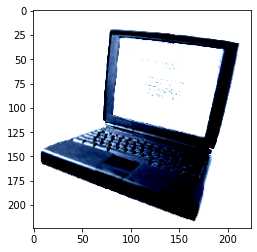

In [28]:
plt.imshow(img.permute(1, 2,0))

In [29]:
embedding = model(img.reshape(1,3,224,224).to(device))

In [31]:
embedding.squeeze()[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.2836, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3871, 0.5631, 4.1611, 0.0000, 0.3979],
        [0.0000, 0.0000, 3.8631, 2.8868, 4.9413, 1.6592, 1.6233],
        [0.0000, 0.0000, 4.2466, 2.5871, 4.7096, 0.6752, 0.9704],
        [0.0000, 0.0000, 0.7469, 0.1128, 0.6937, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.0818, 0.9505, 1.8550],
        [0.0000, 0.0000, 0.0000, 0.5228, 1.9905, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [32]:
img_test = embedding.squeeze()
print(img_test.shape)

torch.Size([512, 7, 7])


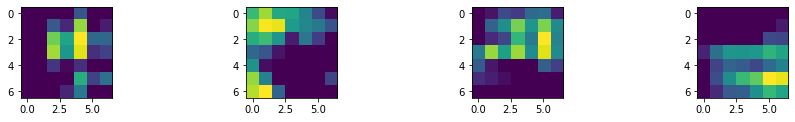

In [37]:
plt.figure(figsize=(64,64))
for i in range(1,5):
    plt.subplot(32,16,i)
    plt.imshow(embedding.squeeze()[i -1].to("cpu").detach().numpy())
plt.show()

In [39]:
# pretrained Model 
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
layers = nn.Sequential(*list(model.children())[:-2])

class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.base_model = layers
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(512*7*7,101)

  def forward(self,x):
    x = self.base_model(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x


net = NeuralNet()
net.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NeuralNet(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Resnet18 fine tuning 

In [40]:
# training function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

epochs = 5

train_loss , train_accuracy = [], []

net.train()

for epoch in range(epochs):
    print('Training')
    running_loss = 0.0
    running_correct = 0

    for data in tqdm(trainLoader):

        data, target = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(data)

        loss = criterion(outputs, target)

        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)

        running_correct += (preds == target).sum().item()

        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(trainLoader.dataset)
    accuracy = 100. * running_correct/len(trainLoader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")


Training


100%|██████████| 190/190 [00:20<00:00,  9.42it/s]


Train Loss: 0.0264, Train Acc: 82.81
Training


100%|██████████| 190/190 [00:18<00:00, 10.25it/s]


Train Loss: 0.0012, Train Acc: 99.03
Training


100%|██████████| 190/190 [00:18<00:00, 10.01it/s]


Train Loss: 0.0004, Train Acc: 99.67
Training


100%|██████████| 190/190 [00:18<00:00, 10.02it/s]


Train Loss: 0.0002, Train Acc: 99.88
Training


100%|██████████| 190/190 [00:19<00:00,  9.90it/s]

Train Loss: 0.0000, Train Acc: 100.00


### Testing 

In [45]:
total = 0
running_correct = 0
test_loss = 0

model.eval()

with torch.no_grad():
  for data in tqdm(valLoader):
    total +=1
    img = data[0].to(device)
    label = data[1].to(device)
    
    pred = net(img)
    loss = criterion(pred,label)

    _, preds = torch.max(pred.data, 1)
    running_correct += (preds == label).sum().item()
    test_loss += loss.item()

100%|██████████| 28/28 [00:02<00:00, 12.54it/s]


In [46]:
test_loss/total

0.17021548923678761

In [47]:
running_correct/len(valLoader.dataset)

0.9642857142857143

In [48]:
for i in valLoader:
  img = i[0][1]
  print(img.shape)
  lab = i[1][1]
  break

torch.Size([3, 224, 224])


In [44]:
pred = net(img.reshape(1,3,224,224).to(device))
print(torch.argmax(pred))
print(encoder.inverse_transform([torch.argmax(pred).item()]))
print(encoder.inverse_transform([lab]))

tensor(5, device='cuda:0')
['airplanes']
['airplanes']


## Generating Embeddings for Dataset

In [49]:
import pandas as pd

In [50]:
embedding_generator = nn.Sequential(*list(net.children())[:-1])

# We trained Network to generate embeddings 
# Then Mapped Resnet embeddings with Actual label 
# when we KNN it will give us real neighbour 

In [51]:
labels = []
images = []

valLoader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=2)

for i in valLoader:
  embeds = embedding_generator(i[0].to(device)).cpu().detach().numpy()[0]
  images.append(embeds)
  labels.append(i[1].item())

In [52]:
embedding_df = pd.DataFrame(images)
labels_df = pd.DataFrame(labels)
labels_df.columns = ["label"]

In [53]:
df = pd.concat([embedding_df,labels_df],axis=1)

In [ ]:
os.chdir("/content/drive/MyDrive/DeepLearningColab/Reverse Image Search")

In [ ]:
df.to_csv("Image_embeddings",index=False)

### PCA

In [54]:
from sklearn.decomposition import PCA

In [55]:
x = df.drop('label',axis=1)
y = df['label']

In [56]:
pca = PCA(n_components=256)
reduced_data = pca.fit_transform(x)

In [57]:
knn = KNeighborsClassifier(n_neighbors=5)

In [58]:
knn.fit(reduced_data,y)

KNeighborsClassifier()

In [59]:
for i in valLoader:
  embeds = embedding_generator(i[0].to(device)).cpu().detach().numpy()[0]
  images.append(embeds)
  labels = i[1].item()
  break

In [60]:
test_plot= i[0].squeeze()
test_plot.shape

torch.Size([3, 224, 224])

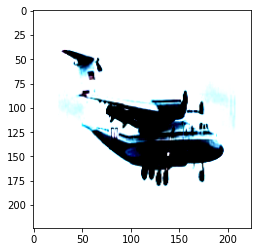

In [61]:
plt.imshow(test_plot.permute(1,2,0))

In [62]:
embeds

array([0.        , 0.        , 0.        , ..., 1.4813846 , 1.1650971 ,
       0.31698132], dtype=float32)

In [63]:
print(encoder.inverse_transform([labels]))
print(labels)

['airplanes']
5


In [64]:
test_point = pca.transform([embeds])

In [65]:
knn.predict(test_point)

array([5])

In [66]:
knn.kneighbors(test_point)

(array([[1.98712410e-04, 1.81945080e+02, 1.87103636e+02, 1.90362512e+02,
         1.94973734e+02]]), array([[214, 425,   5, 183, 209]]))

In [67]:
for i in knn.kneighbors(test_point)[1]:
  print(df.iloc[i]["label"])

214    5
425    5
5      5
183    5
209    5
Name: label, dtype: int64
